In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## Keras

- Machine Leanring library
- High level wrapper 
- Works with tensorflow, CNTK, Theano (default tensorflow)
- Helpful data transformers
- Functional APIs
- Hyper parameters for model tuning
- GPU support for faster traning

 ## Change backend

In [28]:
import os
os.environ['KERAS_BACKEND'] = 'theano'

In [29]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

## Data Loading

- Numpy arrays
- Tensorflow Dataset Objects
- Python generators

## Image classification

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Data download

In [6]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  2902k      0  0:04:37  0:04:37 --:--:-- 2028k05:47  0:01:22  0:04:25 2215k36  0:03:53  0:00:43 3610k    0  0:04:33  0:04:04  0:00:29 3576k  0:04:17  0:00:14 2766k


In [7]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 Feature-importance-session-8.ipynb   Session-2.ipynb
 kagglecatsanddogs_3367a.zip	      Session-3.ipynb
 Kumba_processed_out.csv	      Session-4-pandas-time-series.ipynb
'MSR-LA - 3467.docx'		      Session-5-matplot-lib.ipynb
 PetImages			      Session-6-scikit-learn-basics.ipynb
'readme[1].txt'			      Session-7-Keras-1.ipynb
 Session-1.ipynb


In [12]:
num_skipped = 0 

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
        
print("Removed %d images" % num_skipped)

Removed 1590 images


## Generate a dataset

In [30]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1558,
    image_size=image_size,
    batch_size=batch_size,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1558,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize data

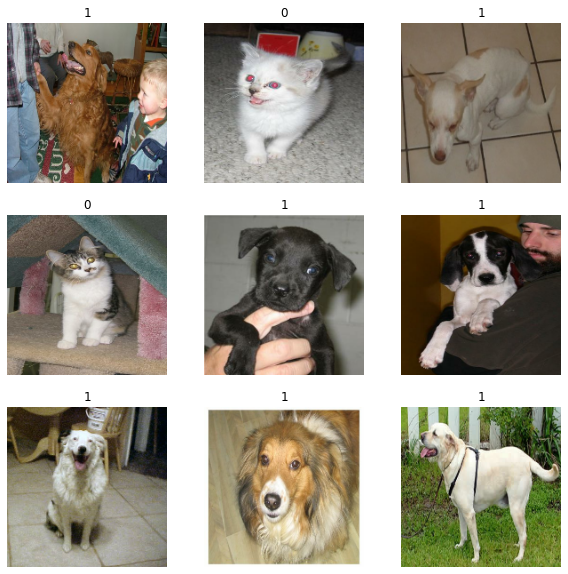

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Data augmentation

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

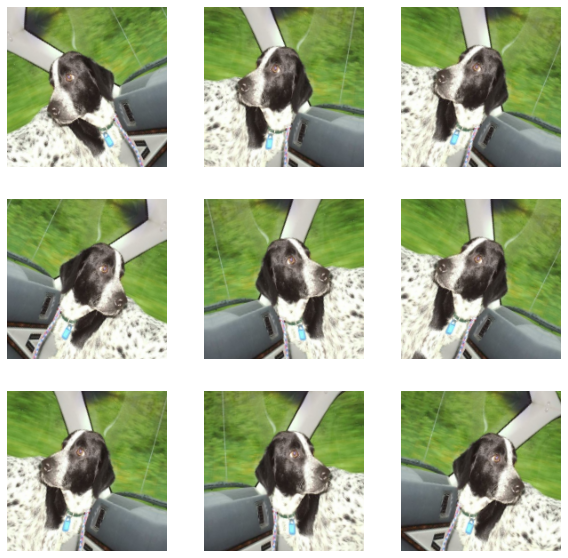

In [32]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Preprocessing

### 1. Part of the model

In [ ]:
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)

### 2. apply to the dataset

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

## Configure the dataset for performance

In [24]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

In [33]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
 

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Train the model

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
 67/586 [==>...........................] - ETA: 40:58 - loss: 0.7366 - accuracy: 0.5868

## Run inference on new data

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

## Basic concepts

- Layers
    - Conv2D
    - SeperableConv2D
- Activation
- Normalization
- Pooling
- Dropout
- Model
- Epochs
- Batches
- Compiling
- Training
- fit
- evalaute
- predict

## Layers